# Script: 3 - preprocessing plan execution
<h4><span style="color:blue">Juan José Hoyos Urcué</span></h4>

## Dataset and python libraries upload

In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
import util_prep as util
import random
from sklearn.preprocessing import MinMaxScaler

file_name = "cleaned.xlsx"
df = pd.read_excel(file_name, na_values = ["999.0","888.0","999","888"])

In [2]:
def show_miss():
    columns_na = df.columns[df.isna().any()].to_list()
    by_col = list()

    for col in columns_na:
        info = (col,df[col].isna().sum())
        by_col.append(info)
    return pd.DataFrame(by_col, columns = ["Variable","Number of NaN values"]).style.hide_index()
show_miss()

Variable,Number of NaN values
height,128
injury_horizontal,4
ulcer_horizontal,73
injury_vertical,4
ulcer_vertical,73
injury_area,4
ulcer_area,73


### Eliminate non-useful records based on the target variable (Nan, excluded patients, loss patients tracking and non-Glucantime patients treated )

In [3]:
df = df[df["cure_or_fail"].notna()] # Delete rowswith Nan in target variable

# Delete excluded patients (labeled as 3)
df = df[df["cure_or_fail"] != 3]

# Delete lost follow up patients (labeled as 2)
df = df[df["cure_or_fail"] != 2]

In [4]:
# delete patients with no glucantime treatment (different of 1 )
df = df[df["prescribed_medication"] == 1]
del df['prescribed_medication'] # delete column, as all are now glucantime patients
df
show_miss() # with this can be observed that those who did not have glucantime dosage where patients with other treatment

Variable,Number of NaN values
height,128
injury_horizontal,4
ulcer_horizontal,32
injury_vertical,4
ulcer_vertical,32
injury_area,4
ulcer_area,32


### Class Distribution - Target Variable 

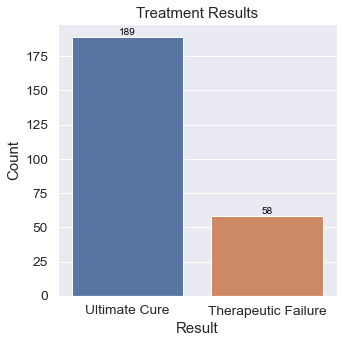

In [5]:
labels = ["Ultimate Cure","Therapeutic Failure"]
values = [df["cure_or_fail"].value_counts()[i] for i in range(len(labels))]
target_data = pd.DataFrame(zip(labels,values), columns = ["Result", "Count"])
util.plot_class_distr(target_data)

### Transform infection department  into numerical scale.

In [6]:
pd.DataFrame(df["infection_department"].value_counts())

,infection_department
NARIÑO,158
TOLIMA,32
.,19
VALLE,17
CHOCO,17
CAUCA,2
SANTANDER,1
GUAVIARE,1


In [7]:
df["infection_department"] = pd.factorize(df["infection_department"])[0]
pd.DataFrame(df["infection_department"].value_counts())

,infection_department
0,158
5,32
4,19
1,17
2,17
6,2
3,1
7,1


### Delete variables by correlation
### before deletion

<AxesSubplot:>

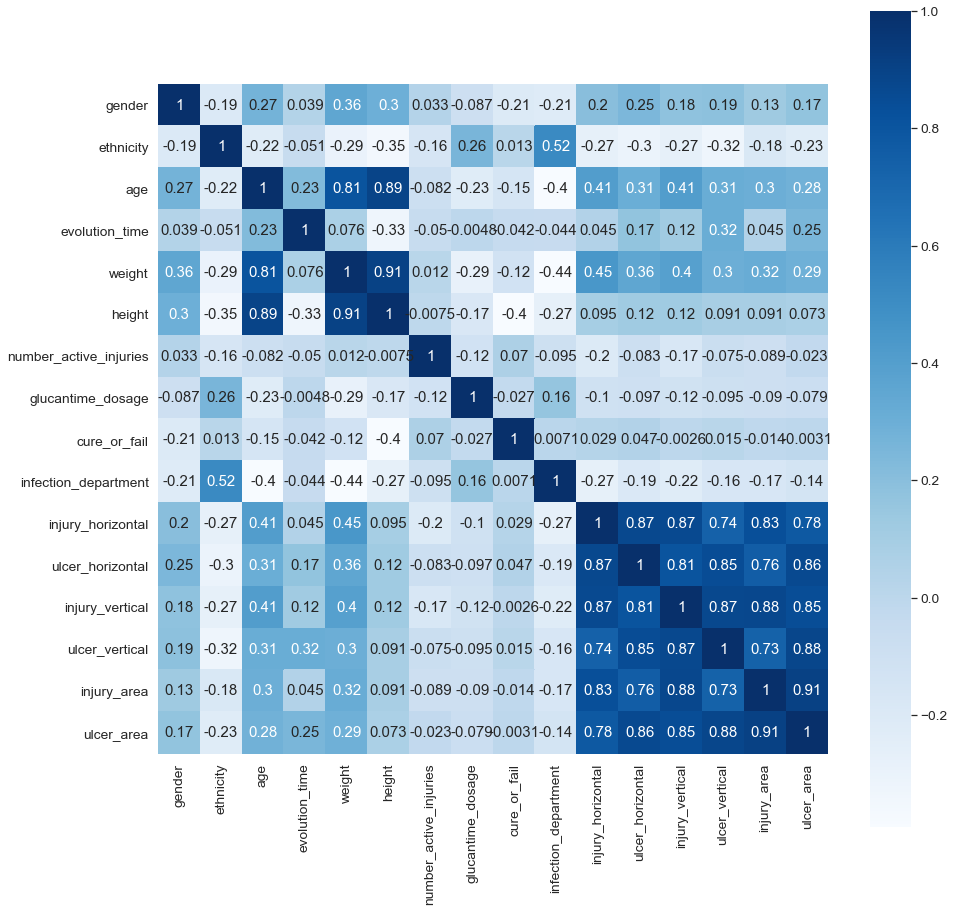

In [8]:
size = 15
plt.figure(figsize = (size,size))
sns.heatmap(df.corr(), square = True, annot=True, cmap = "Blues", robust = True)

In [9]:
# deletion process

to_delete = ["ulcer_horizontal",
            "ulcer_vertical",
            "injury_horizontal",
            "injury_vertical",
            "weight",
            "injury_area"]

df = util.clean_by_correlation(df, to_delete)

### after deletion

<AxesSubplot:>

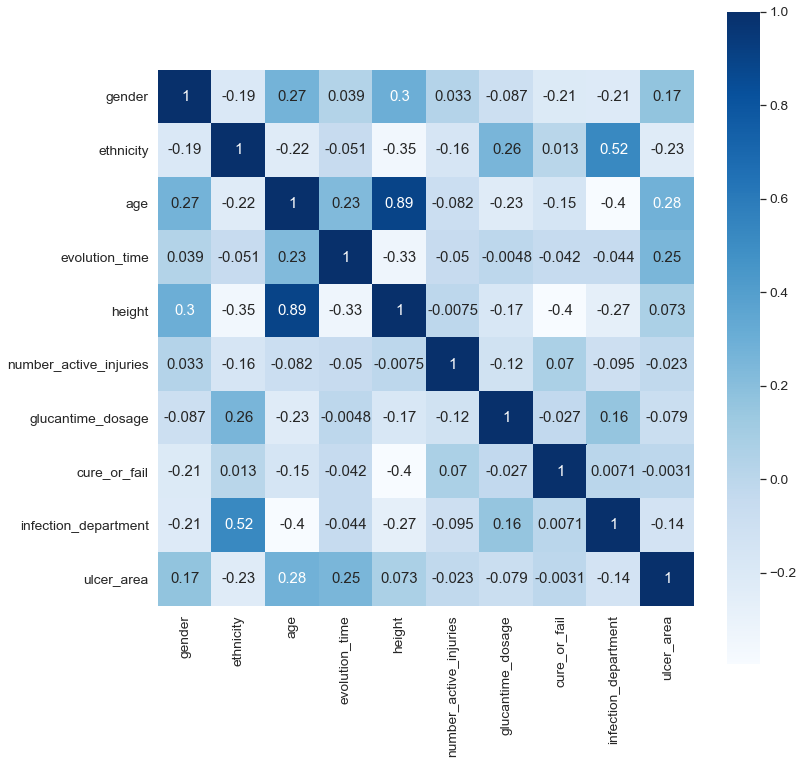

In [10]:
size = 12
plt.figure(figsize = (size,size))
sns.heatmap(df.corr(), square = True, annot=True, cmap = "Blues", robust = True)

### What about Nan Values after Correlation Filter

In [11]:
show_miss()

Variable,Number of NaN values
height,128
ulcer_area,32


In [12]:
# lets change them by the statistic median
median_height = df["height"].median()
median_area = df["ulcer_area"].median()

df["height"] = np.where(df["height"].isnull(),median_height, df["height"])  
df["ulcer_area"] = np.where(df["ulcer_area"].isnull(),median_area, df["ulcer_area"])  

## Normalize dataset

### statistical description before normalization

In [13]:
df.describe()

,gender,ethnicity,age,evolution_time,height,number_active_injuries,glucantime_dosage,cure_or_fail,infection_department,ulcer_area
count,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000
mean,0.732794,1.753036,20.761134,7.199190,113.429150,3.105263,20.013684,0.234818,1.251012,186.357100
std,0.443400,0.979330,16.741568,37.803064,11.645249,1.901287,1.250460,0.424746,1.946894,353.947982
min,0.000000,1.000000,2.000000,1.000000,83.000000,1.000000,18.000000,0.000000,0.000000,4.712389
25%,0.000000,1.000000,7.000000,1.000000,113.000000,2.000000,19.633971,0.000000,0.000000,40.393419
50%,1.000000,1.000000,18.000000,2.000000,113.000000,3.000000,19.975611,0.000000,0.000000,76.969020
75%,1.000000,3.000000,31.000000,5.000000,113.000000,4.000000,20.246951,0.000000,2.000000,193.207948
max,1.000000,5.000000,65.000000,421.000000,143.000000,8.000000,36.400002,1.000000,7.000000,4033.019569


In [14]:
scaler = MinMaxScaler() 
scaled_values = scaler.fit_transform(df) 
df.loc[:,:] = scaled_values

### statistical description after normalization

In [15]:
df.describe()

,gender,ethnicity,age,evolution_time,height,number_active_injuries,glucantime_dosage,cure_or_fail,infection_department,ulcer_area
count,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000
mean,0.732794,0.188259,0.297796,0.014760,0.507152,0.300752,0.109439,0.234818,0.178716,0.045092
std,0.443400,0.244832,0.265739,0.090007,0.194087,0.271612,0.067960,0.424746,0.278128,0.087865
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.079365,0.000000,0.500000,0.142857,0.088803,0.000000,0.000000,0.008858
50%,1.000000,0.000000,0.253968,0.002381,0.500000,0.285714,0.107370,0.000000,0.000000,0.017937
75%,1.000000,0.500000,0.460317,0.009524,0.500000,0.428571,0.122117,0.000000,0.285714,0.046793
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [16]:
print("____________________________________________________________")
print("Columns:")
print("____________________________________________________________")
for e in df.columns.to_list():
    print(e)
print("____________________________________________________________")
print("The pre-processed dataset has {} rows and {} columns".format(df.shape[0],df.shape[1]))
print("____________________________________________________________")

____________________________________________________________
Columns:
____________________________________________________________
gender
ethnicity
age
evolution_time
height
number_active_injuries
glucantime_dosage
cure_or_fail
infection_department
ulcer_area
____________________________________________________________
The pre-processed dataset has 247 rows and 10 columns
____________________________________________________________


## Save preprocessed dataset

In [17]:
df.to_excel("preprocesado.xlsx", index = False)